<a href="https://colab.research.google.com/github/GerardvandenEynden/FintechAI-Solutions-RAG-SYSTEM/blob/main/presentatie_RAG_system_(14_11_2025).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FintechAI Solutions RAG-SYSTEM
Colab-notebook: /content/drive/MyDrive/Colab Notebooks/presentatie RAG-system (14-11-2025).ipynb


![RAG_system[1].png](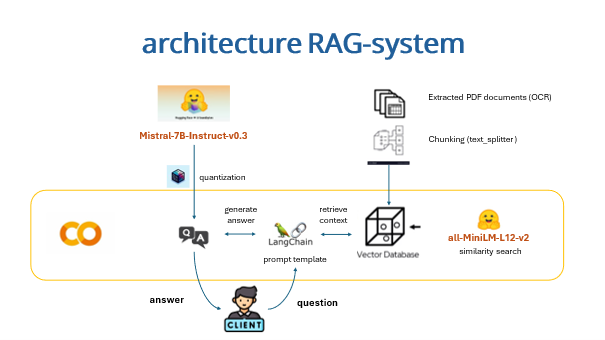)

#### keys to the model-components:
1. The yellow perimeter in the picture above defines the Colab notebook environment in which al working components of the model are assembled (vectorstore, chatbot, agent). This is in Google cloud in this set-up but is small enough to be transferred to a PC.
2. The user-interface for the client is not designed and remains in the Colab notebook. One can experiment with interactions by entering questions in raw prompt-code. Also, no metric is applied, this is to be developed further.
3. Before the model can be used, two preparations must be completed (top half of the picture):    
- **quantization** of the Mistral Q&A model (left)
- **vectorization** of the chunked text to be questioned (right)
4. Process-flow: The LangChain pipeline from HuggingFace is used as an agent to perform a similarity search on its vectorstore. It ranks the chunks based on cosine-similarity and returns the top-3 chunks that are most simular to the question.
5. The small Mistral model (SML) answers the (vectorized) questions based on the top-3 results of the similarity search. For this a elaborate prompt is defined.


### introduction

This is a small and simple Proof of Concept (PoC) of a Retrieval-Augmented Generation (RAG) system that can be tutored to usecases by adjusting its components and parameters. The aim is to show that the results of an on-premise and open-source model can be as good as the results from well known controlled (LLM) models like OpenAI's chatGPT for example. It functions as a simple platform to try out different solutions according to the cirumstances.

In plain terms my small language model (SML) answers questions in human language, but uses paragraphs retrieved with sentence similarity techniques to formulate the answer. This is a two-step-process: retrieve context first and answer the question second.
- For the questioning and answering I use the **Mistral-7B** model and reduce its size to only 4,2GB, so that it will fit on a PC.
- For the context retrieval and vectorization I use HuggingsFace's well known **all-miniLM**.


#### Improvements can be made by:
1. choosing a different model for the Q&A or vectorization tasks
2. apply relevant metrics to the output (evaluation pipeline)
3. apply different chunking techniques
4. start with a live set of documents (usecases)
5. build a user interface on a website of Power BI page
6. fine tune the Q&A model to specific tasks/ develop trainingdata
7. add extra contextual data in the vectorstore




### notebook set-up
You will need an account on HuggingFace and a token (secret) to access the models used in this notebook. This notebook stores the model in Googles Colab cloud environment but this path can be altered to a local drive. In that case there is no need to mount Google Drive. Loading and quantizising the model takes up about 7 minutes and uses 5,5 GB of RAm and 7,6 GB of GPU. Answering a question takes up around 2-3 minutes.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import os
# when the model is loaded it creates a double temp file (4,7GB) which takes up extra diskspace.

blobs_path = '/content/drive/MyDrive/Colab Notebooks/huggingface_models/Mistral-7B-Instruct-v0.3_8bit/models--mistralai--Mistral-7B-Instruct-v0.3/blobs'

if os.path.exists(blobs_path):
    print(f"Listing contents of '{blobs_path}':")
    !ls -lh "{blobs_path}"
else:
    print(f"The directory '{blobs_path}' does not exist.")

Listing contents of '/content/drive/MyDrive/Colab Notebooks/huggingface_models/Mistral-7B-Instruct-v0.3_8bit/models--mistralai--Mistral-7B-Instruct-v0.3/blobs':
total 14G
-rw------- 1 root root  24K Nov 16 14:47 050e5515d49376fc01e4837d031902c63af98111
-rw------- 1 root root 574K Nov 16 14:54 37f00374dea48658ee8f5d0f21895b9bc55cb0103939607c8185bfd1c6ca1f89
-rw------- 1 root root  414 Nov 16 14:54 451134b2ddc2e78555d1e857518c54b4bdc2e87d
-rw------- 1 root root 4.7G Nov 16 14:51 8c0e72f148366b6a3709e002a98706a33d31aec8515090c856c95b2044f92ae0
-rw------- 1 root root 1.9M Nov 16 14:54 8d7d23136b474a3df1182ed829db19984e295ee7
-rw------- 1 root root 4.3G Nov 16 14:51 905dd405363e43d95779c1c1155a2dbfd36155914ae95dbd934e12e490cfb4ca
-rw------- 1 root root 138K Nov 16 14:54 940a9c375c745ccbf0bebc5bedcec924d71827aa
-rw------- 1 root root  601 Nov 16 14:43 9f913dc05d66cfb23c16e3c93b3cc4899813dfa6
-rw------- 1 root root  116 Nov 16 14:53 b6bea2642bc3fe80f392111d52af91d1563a8de2
-rw------- 1 root r

In [ ]:
! pip install langchain-core langchain_community langchain-huggingface
! pip install wikipedia pandas numpy requests rich pyyaml

In [4]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


## Step 1: understand your Data

### retrieve a reference article
To keep things quick, we’ll use a single reference document: the English **Wikipedia** page for the Roman Empire.
In a production system you’d likely combine multiple sources, but one page is enough to demo the workflow.

In [5]:
import wikipedia, textwrap

# Disable auto-suggest so we get the exact page
page = wikipedia.page("Roman Empire", auto_suggest=False)
wikipedia_text = page.content

print("First 1200 characters of the article:\n")
print(textwrap.fill(wikipedia_text[:1200], 110))


First 1200 characters of the article:

During the classical period, the Roman Empire controlled the Mediterranean and much of Europe, Western Asia,
and North Africa. The Romans conquered most of these territories in the time of the Republic, and it was ruled
by emperors following Octavian's  assumption of power in 27 BC. Over the 4th century AD, the empire split into
western and eastern halves. The western empire collapsed in 476 AD, while the eastern empire endured until the
fall of Constantinople in 1453. By 100 BC, the city of Rome had expanded its rule from the Italian peninsula
to most of the Mediterranean and beyond. However, it was severely destabilised by civil wars and political
conflicts, which culminated in the victory of Octavian over Mark Antony and Cleopatra at the Battle of Actium
in 31 BC, and the subsequent conquest of the Ptolemaic Kingdom in Egypt. In 27 BC, the Roman Senate granted
Octavian overarching military power (imperium) and the new title of Augustus, marking

### Q&A test-set
Let’s jot down a few questions that our finished system should handle. Capturing these **early** gives us a mini test‑set for later.
These questions are also used to test Large models as a comparison. For finetuning the Q&A model an new process has to be started. The model can be trained on generated Q&A-pairs that are tutored to the task.

In [6]:
sample_qa = [
    {"question": "When did the Roman Empire collapse?", "answer": "The west Roman Empire fell in 476 CE and the Easy laster until the fall of Constantinopol in 1453."},
    {"question": "Who was the first emperor of the Roman Empire?", "answer": "Augustus (formerly Octavian)"},
    {"question": "What were the main languages spoken across the Roman Empire?", "answer": "Latin in the West and Greek in the East"},
    {"question": "What monumental arena in Rome hosted gladiatorial games?", "answer": "The Colosseum"},
]

for qa in sample_qa:
    print(f"Q: {qa['question']}\nA: {qa['answer']}\n")


Q: When did the Roman Empire collapse?
A: The west Roman Empire fell in 476 CE and the Easy laster until the fall of Constantinopol in 1453.

Q: Who was the first emperor of the Roman Empire?
A: Augustus (formerly Octavian)

Q: What were the main languages spoken across the Roman Empire?
A: Latin in the West and Greek in the East

Q: What monumental arena in Rome hosted gladiatorial games?
A: The Colosseum



### split text

we apply a straight forward way of chunking the text using LangChain text-splitter.

In [7]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

In [8]:
# Split the document into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
text_splits = text_splitter.split_text(wikipedia_text)
document_splits = text_splitter.create_documents(text_splits)

### index dataset

This section walks through loading the **Wikipedia article on the Roman Empire** into an in‑memory vector store (adapted from [https://python.langchain.com/docs/tutorials/rag/](https://python.langchain.com/docs/tutorials/rag/)):

- To calculate the embeddings, I use the well-known all-MiniLM SBERT model from HuggingFace which is only 150 MB in size and is loaded locally every time the notebook is run. This requires access to the HuggingFace website and an access token. This is a small open-source model that is used on-premises.
- The InMemoryVectorStore calls the embeddings object (which is backed by all-MiniLM-L12-v2) to generate an embedding vector for the chunk of text. Once generated ‘vector_store.add_documents()’ stores both the original Document object (which includes the text chunk and any metadata) and its corresponding embedding vector in an internal data structure (in-memory vector_store).


The indexed variable then contains a list of the unique IDs generated for each added document.

This variable is stored in Google Colab's cloud, as is the model, but it can be loaded persistantly to a local drive for privacy reasons. However, because of the small size of the model and vectorstore memory usage is no issue.

In [9]:
# Embed and index the chunks
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L12-v2")
vector_store = InMemoryVectorStore(embeddings)
indexed = vector_store.add_documents(documents=document_splits)

##Step 3: Q&A-model quantization & Load
I use the HuggingFace Transformers library and the open-source model from their site:


- https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3



The model we use for our Q&A task is the open-source Mistral-7B model which is 18GB in size and saved to MyDrive. This is reduced in size by means of quantization for which BitsAndBytes is used. The reduced size is 4,23GB. We need to specify the following:
1. model selection: mistralai/Mistral-7B-Instruct-v0.3
2. specify cahche_dir: /content/drive/MyDrive/Colab Notebooks/huggingface_models/Mistral-7B-Instruct-v0.3_8bit
3. specify quantization parameters: 8bit, nf4



In [10]:
from huggingface_hub import login
login(new_session=False)

In [11]:
from transformers import pipeline, BitsAndBytesConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from langchain_huggingface import HuggingFacePipeline

### 8bit quantization

#### Quantization from 16bit to 8bit weights in the Mistral Q&A-model reduces the size in about half.
- This does not affect the quality of the answers much, the model works just as fine, on the Wikipedia text. This is probably because the closed questions and answers are straight forward and an easy task for the model (little nuance needed), but also because the context provided is important. The similarity search works very effectively and makes answering more consistent (low chance of hallucination).




It is also possible to install Mistral locally on the PC without quantization. The size is around 18 GB and can be accessed from the locally run notebook using Ollama. In that configuration all components are stored and used locally without any link to other computers. Using a set up in Google’s Colab cloud environment implicates that the data is not as well protected.

I use BitsAndBytes for quantization. bitsandbytes is a CUDA extension, which means it must work closely with your PyTorch version and the underlying GPU drivers. Sometimes the installation is not complete or compatible.
- The --upgrade (-U) flag ensures that you get the latest version, which  helps with compatibility issues.

In [ ]:
#installing bitsandbytes is problematic:
#It is installed three times (see below) and in a specific order and then runtime is restarted.
#Then, pip install -U bitsandbytes is executed again in the cell preceding the load function.
!pip install bitsandbytes accelerate

In [ ]:
!pip install -U bitsandbytes

In [ ]:
pip install -U bitsandbytes

In [15]:
model_id = "mistralai/Mistral-7B-Instruct-v0.3"
model_save_path = "/content/drive/MyDrive/Colab Notebooks/huggingface_models/Mistral-7B-Instruct-v0.3_8bit"

A quick fix with further reduction of memory use is quantization of the quantization constants (scalars) that are used to replace the eliminated bits in the weights. These can be reduced to 4bits as well and do minimally impact the working of the model, as opposed to the initial quantization.

In [16]:
# For 8-bit quantization:
nf4_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_4bit_quant_type="nf4", # not used for 8-bit but good practice to include
    bnb_4bit_use_double_quant=False, # not used for 8-bit
    bnb_4bit_compute_dtype=torch.bfloat16 # not used for 8-bit
)

In [17]:
import warnings

# Filter out the specific bitsandbytes UserWarning
warnings.filterwarnings(
    "ignore",
    message="MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization",
    category=UserWarning
)

### load model

In [ ]:
# local_files_only=True added (add # to reload)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=nf4_config,
    dtype=torch.bfloat16,
    device_map="balanced",
    cache_dir=model_save_path
    #local_files_only=True
)

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained(local_model_path, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=model_save_path)

## Step 4: set up your Agent

#### HuggingFacePipeline (from LangChain):

This is a wrapper provided by LangChain that allows you to use a Hugging Face pipeline (which you set up with your quantized Mistral model and tokenizer) as if it were a standard LangChain Language Model (LLM). LangChain needs its components to adhere to a certain interface (like having an invoke method to generate text). The HuggingFacePipeline class adapts the Hugging Face pipeline so it fits seamlessly into the LangChain ecosystem. It essentially bridges the gap between the raw Hugging Face pipeline and LangChain's framework.


LangChain as an "agent" (or orchestration layer): You're correct in saying LangChain acts as an "agent" or, more accurately, an orchestration layer in your setup. LangChain doesn't itself perform the sentence similarity search or the text generation. Instead, it provides the structure and tools to connect different components:

- It uses the InMemoryVectorStore and the HuggingFaceEmbeddings (which you got from Hugging Face) to perform the retrieval (the sentence similarity search).
- It uses the HuggingFacePipeline (which wraps your Mistral model and tokenizer from Hugging Face) to perform the text generation based on the retrieved context and your question.

The RAG class you defined is a simple example of a LangChain "chain" or "agent" that orchestrates the flow: it takes a question, uses the vector store to retrieve relevant documents, and then passes those documents and the question to the LLM (wrapped by HuggingFacePipeline) to generate an answer.


So, HuggingFacePipeline is a specific component within LangChain that lets you plug in a Hugging Face model, and LangChain is the framework that helps you wire together this LLM component with other components like your vector store to build your RAG system.

### construct pipeline
A pipeline in Hugging Face is a higher-level abstraction that wraps a model and its tokenizer to perform a specific task (like "text-generation").

In [21]:
# Create pipeline from loaded model and tokenizer
pipe = pipeline(
     "text-generation",
     model=model,
     tokenizer=tokenizer,
     dtype=torch.bfloat16,
     device_map="auto",
     max_new_tokens=500 # Added max_new_tokens to prevent infinite generation
 )

Device set to use cuda:0


#### Quick-test to verify the correct functioning of the pipeline:

In [22]:
messages = [
    {"role": "user", "content": "Who are you?"},
]

# Extract the user's question for printing
user_question = messages[0]['content']

response = pipe(messages)
# Extract and print only the assistant's content
assistant_answer = response[0]['generated_text'][1]['content']

print(f"Q: {user_question}\nA: {assistant_answer}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Q: Who are you?
A:  I am a model of an artificial intelligence designed to answer questions, provide information, and assist with various tasks. I was created by Mistral AI.


### create system prompt

In [23]:
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.language_models.llms import LLM # Import base LLM class


class RAG:
    def __init__(self, vector_store: InMemoryVectorStore, llm: LLM): # Change type hint to base LLM
        self.vector_store = vector_store
        self.llm = llm

        self.SYSTEM_PROMPT = """
You are a problem solving model working on task_description XML block:

<task_description>
Answer the question using information from one of the context paragraphs.
The answer should should contain all important information from the context paragraph but stay short, one sentence maximum.
</task_description>
"""

        self.PROMPT_TEMPLATE = """
{system_prompt}

Now for the real task, solve the task in question block based on the context in context block.
Generate only the solution, do not generate anything else.

<context>
{context}
</context>

<question>
{question}
</question>
"""

    def retrieve(self, question: str, k: int = 5):
        return self.vector_store.similarity_search(question, k=k)

    def generate(self, question: str, context_docs):
        context = "\n\n".join(doc.page_content for doc in context_docs)
        # Combine system prompt, context, and question into a single string
        prompt = self.PROMPT_TEMPLATE.format(
            system_prompt=self.SYSTEM_PROMPT,
            context=context,
            question=question
        )
        # Call the LLM with a single string input
        # The method name might vary depending on the specific LLM class,
        # but 'invoke' is common in LangChain
        response = self.llm.invoke(prompt)
        # Extract and return only the generated text from the response
        return response.strip()

    def answer(self, question: str):
        return self.generate(question, self.retrieve(question))

In [24]:
hf_llm = HuggingFacePipeline(pipeline=pipe)

In [25]:
tuned_rag = RAG(vector_store=vector_store, llm=hf_llm)

##Step 5: test your Model

In [27]:
import re

question = "When did the roman empire collapse?"
raw_answer = tuned_rag.answer(question)
answer = re.search(r"<solution>(.*?)</solution>", raw_answer, re.DOTALL)
solution = answer.group(1).strip()

# It may be nescesarry to run this cell twice in case the regex does not work
print(f"Q: {question}\nA: {solution}\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Q: When did the roman empire collapse?
A: The Western Roman Empire collapsed in 476 AD.



#### Raw_Answer
The following output of the raw_answer shows the context and the working of the Q&A model.

In [28]:
print(tuned_rag.answer("When did the roman empire collapse?"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


You are a problem solving model working on task_description XML block:

<task_description>
Answer the question using information from one of the context paragraphs.
The answer should should contain all important information from the context paragraph but stay short, one sentence maximum.
</task_description>


Now for the real task, solve the task in question block based on the context in context block.
Generate only the solution, do not generate anything else.

<context>
=== Fall in the West and survival in the East ===
The Western Roman Empire began to disintegrate in the early 5th century. The Romans fought off all invaders, most famously Attila, but the empire had assimilated so many Germanic peoples of dubious loyalty to Rome that the empire started to dismember itself. Most chronologies place the end of the Western Roman Empire in 476, when Romulus Augustulus was forced to abdicate to the Germanic warlord Odoacer.

During the classical period, the Roman Empire controlled the Medit

### understand the output

#### human evaluation
Here we also develop a working version of the system prompt that instructs the Q&A model together with the question and context (retrieved). Instructions can be added or removed, in a trial-and-error approach, to achieve the best answers. With best I mean the most relevant answers, not so much the accuracy. So, evaluation by a human is crucial.

- An apparently logical metric would be a rouge score [0,1] which compares the words (n-grams) in the answer given by the model, to the prepared answer in the test-set of questions and answers. It is a measure of similarity, based on accuracy. This works well with closed questions and answers (concise).
- At this stage we focus on the form of the answers and output and how to further fine tune them. What is learned here can be used to develop the fine-tuned model later on. In this stage we can tweak the number of retrieved text-chunks (initially set to k=5 chunks) and the size of the retrieved context (n=500 tokens).



In [29]:
question = "Who was the first emperor of the Roman Empire?"
raw_answer = tuned_rag.answer(question)
answer = re.search(r"<solution>(.*?)</solution>", raw_answer, re.DOTALL)
solution = answer.group(1).strip()

print(f"Q: {question}\nA: {solution}\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Q: Who was the first emperor of the Roman Empire?
A: Augustus was the first emperor of the Roman Empire.



In [40]:
question = "What were the main languages spoken across the Roman Empire?"
raw_answer = tuned_rag.answer(question)
answer = re.search(r"<solution>(.*?)</solution>", raw_answer, re.DOTALL)
solution = answer.group(1).strip()

print(f"Q: {question}\nA: {solution}\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Q: What were the main languages spoken across the Roman Empire?
A: The main languages spoken across the Roman Empire were Latin and Greek.



In [32]:
question = "What monumental arena in Rome hosted gladiatorial games?"
raw_answer = tuned_rag.answer(question)
answer = re.search(r"<solution>(.*?)</solution>", raw_answer, re.DOTALL)
solution = answer.group(1).strip()

print(f"Q: {question}\nA: {solution}\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Q: What monumental arena in Rome hosted gladiatorial games?
A: The Colosseum hosted gladiatorial games.

